# 1.WEB SCRAPING

Web scraping, also called <i>web harvesting</i> or <i>web data extraction</i> consists in extracting data from websites.
To do this, we will use <i>BeautiflSoup Python library</i>.

In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
from math import *
from prepro import *
import json
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/livialilli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/livialilli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Information Dataset

Let's start making our first matrix, which represents for each announcement the following fields:

* Price;

* Locali;

* Superficie;

* Bagni;

* Piano.


We pick <i>n</i> = 10000 announcements; it means that we scrap <b>400 webpages</b> (each webpage contains 25 announcements). It's possible that not all the announcements have all the fields mentioned above: in this case we just not consider them.


       
Here follow all the functions used to <i>clean up</i> all fields' values, just consider the parts we want. For example, it's possible to meet in price's fields, in addiction to the price value, also symbols like "€", so we just drop off all of them. 

We want to apply this kind of procedure for all the fields, so we build these functions for this scope.

Before starting we want to specify some choices done for convention by us.

The first one is that when in "Locali", "bagni", "piano" fields is specified the "+" symbol, we just not consider it, taking in consideratiomn just the number given.

The second one is that in "prezzo" field sometimes there is not the real value, but "PREZZO SU RICHIESTA": so we decide to consider it as a zero. When there is 0, we have a negotiable price.

The third one is that in "piano" field, not always the values are numbers; it can be possible to discover symbols like "A" (staying for Attic), etc...
So we have reported a table with the correspondent numbers we have choosen to give to this terms.






In [2]:
pd.DataFrame([-3, -2, -1, 0], index = ["S", "R", "A", "T"], columns=["Piano Value"])

,Piano Value
S,-3
R,-2
A,-1
T,0


In [ ]:
def price(d):
    try:

        price = d[0].contents[0].replace("\n", "").replace("€ ","").replace('PREZZO SU RICHIESTA',"0").strip()
    except:
        price = d[0].contents[0].get_text().replace("\n", "").replace("€ ","").replace('PREZZO SU RICHIESTA',"0").strip()
    
    price = price.replace(".","")
    price = int(price)

    return price



In [ ]:
def locali(d):
    local = d[1].get_text().replace("\xa0","").replace("locali", "").replace("+","").strip()
    loacal = int(local)
    return local

In [ ]:
def superficie(d):
    superf = d[2].get_text().replace("da ","").replace("\xa0m2","").replace("superficie","").replace(".","").strip()
    superf = int(superf)
    return superf

In [ ]:
def bagni(d):
    bath = d[3].get_text().replace("\xa0","").replace("bagni", "").replace("+","").strip()
    bath = int(bath)
    return bath

In [ ]:
def piano(d):
    floor = d[4].get_text().replace("\xa0", "").replace("\n","").replace("piano","").replace("A","-1").replace("T","0").replace("R","-2").replace("S","-3").replace("+", "").strip()
    floor = int(floor)
    return floor

In [ ]:
#choose number of ann to put in the function
def scraping(n_ann):
    df_info = pd.DataFrame(index=['price', 'locali', 'superficie', 'bagni', 'piano'] )
    
    
    j = 1
    for i in range(1,n_ann+1):

        url = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i)
        html = urlopen(url)
        soup = BeautifulSoup(html, 'lxml')

        mydivs = soup.findAll("div", {"class": "listing-item_body--content"})

        for a in mydivs:

            ann = "announcement"+ str(j)

            data = a.findAll("li", {"class":"lif__item"})

            if len(data) == 6:
                #print(ann, url)

                pr = price(data)

                local = locali(data)

                sup = superficie(data)
                
                bathrooms = bagni(data) 

                floor = piano(data)
                
                df_info[ann] = [pr, local, sup,bathrooms,floor]
                j += 1
                

            else:
                pass
        

    return df_info
    
    

In [ ]:
##### for now, we scrap 50 webpages
df = scraping(400)

In [ ]:
df = df.T


In [ ]:
df.to_pickle("info.pkl")



In [3]:
df1= pd.read_pickle("info.pkl")

In [4]:
df1.head(10)

,price,locali,superficie,bagni,piano
announcement1,225000,2,50,1,1
announcement2,300000,2,46,1,4
announcement3,425000,3,72,2,4
announcement4,400000,3,60,1,3
announcement5,500000,3,89,2,3
announcement6,574000,4,89,2,5
announcement7,669000,5,86,2,4
announcement8,657000,5,87,2,5
announcement9,257000,3,61,1,1
announcement10,325000,2,60,1,3


## Description Dataset

Now it's the moment for our second matrix. It must show for every couple (announcement, word) the correspondent TFIDF value.
So before starting, let's take a look to the mean of this value.

#### An introduction to TF-IDF

<b>TF-IDF</b> stands for <i>“Term Frequency — Inverse Data Frequency”</i>. 

At first, let's see what this term means mathematically.

<b>Term Frequency</b> (tf): it gives us the frequency of the <i>i</i>-word in each <i>j</i>-announcement. It is the ratio of number of times the word appears in an announcement compared to the total number of words in that announcement. 
It <b>increases</b> as the number of occurrences of that word within the announcement increases. 
<b>Each announcement has its own TF</b>.
    
$$ tf_{i,j} = \frac{n_{i,j}}{\sum_{i}{n_{i,j}}} $$

Where:
* $n_{i,j}$ = number of times the <i>i</i>-word appears in <i>j</i>-announcement;
* $\sum_{i}{n_{i,j}}$ = total of words in the <i>j</i>-announcement.



<b>Inverse Data Frequency</b> (idf): it is used to compute the weight of words across all announcement. 
The words that occur <b>rarely</b> in the corpus have a <b>high</b> IDF score. 
It is given by the equation below.
 $$ idf_i = \lg{\frac{N}{df_{i}}} $$
 
Where 
* N = total of announcements;
* $df_i$ = number announcements containing <i>i</i>-word.


Combining these two we come up with the <b>TF-IDF score</b>:

$$ TFIDF_{i,j} = TF_{i,j} * IDF_i $$



#### Our Matrix

Now that we have seen what the TFIDF means, we can start building our matrix.

First of all, we create a function called "description" which creates a dictionary to save, for every announcement, the list of all its words. Obviusly, before building the dictionary, we preprocess all the words removing Italian Stopwords, Punctuation and applying the Italian stemming.


Then we wanna associate to each "cleaned" word, a term ID, saving this into a dictionary called "term". Now we can have our Inverted Index dictionary, where for every term ID, there is a list of all the announcements which contain that word.


So it's possible to compute our TFIDF, creating the dataframe wanted!





In [ ]:
def description(n_ann):
    c =1
    
    
    wd = {}
    for i in range(1, n_ann+1):

        url = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i)
        html = urlopen(url)
        soup = BeautifulSoup(html, 'lxml')

        mydivs = soup.findAll("div", {"class": "listing-item_body--content"})

        for a in mydivs:

            ann = "announcement"+ str(c)

            data = a.findAll("li", {"class":"lif__item"})



            if len(data) == 6:
                #print(ann, url)




                linkd = a.find("a")
                urld = linkd.get("href")  
                htmld = urlopen(urld)
                soupd = BeautifulSoup(htmld, 'lxml')
                descr = soupd.find("div", {"class":"col-xs-12 description-text text-compressed"}).get_text()
                descr = stop(descr)
                descr = punctuation(descr)
                descr = stemmer(descr)
                

                wd[ann] = descr 
                c +=1

            else:
                pass
       
    return wd
#wd dict where for each ann there is a list of its words

In [ ]:
#ann: list of words with eventual rep.
voc = description(400)


In [ ]:
len(voc.keys())

In [ ]:
jv = json.dumps(voc)
f0 = open("voc.json","w")
f0.write(jv)
f0.close()



In [5]:
with open("voc.json") as f0:
    voc = json.load(f0)

In [6]:
#I create words, a list of all the words in all the descr. repeated just one time
def set_words(voc):
    w = list(voc.values())
    words = []
    for l in w:
        words+=l
    words

    words = set(words)
    return words

words = set_words(voc)
words = list(words)

In [7]:
term = {}

for i in range(len(words)):
    ID = "term_"+ str(i)
    term[words[i]] = ID


In [ ]:
#for wordID a list of its anns
inv_index = {}
for word in words:
    for el in voc:
        term_w = term[word]
        if word in voc[el] and term_w not in inv_index.keys():
            inv_index[term_w] = [el]
        elif word in voc[el] and term_w in inv_index.keys():
            inv_index[term_w].append(el)

In [ ]:
jv = json.dumps(inv_index)
f0 = open("inv_index.json","w")
f0.write(jv)
f0.close()


In [8]:
with open("inv_index.json") as f0:
    inv_index = json.load(f0)

In [9]:
inv_index2 = {}
for ann in tqdm(list(voc.keys())):
    for word in words:
        term_w = term[word]
        #numerator of tf
        num_tf = voc[ann].count(word)
        den_tf = len(voc[ann])
        TF = num_tf / den_tf
        num_idf = len(voc.keys())
        den_idf = len(inv_index[term_w])
        IDF = log(num_idf/den_idf)
        TFIDF = TF * IDF
        
        if term_w not in inv_index2:
            inv_index2[term_w] = [(ann, TFIDF)]
        else:
            inv_index2[term_w].append((ann, TFIDF))

100%|██████████| 5015/5015 [04:50<00:00, 17.24it/s]  


In [ ]:
df_descr = pd.DataFrame(0, index=list(voc.keys()), columns=list(term.values()))

In [ ]:
n_ann = len(voc.keys())
for word in tqdm(words):
    ID = term[word]
    values = []
    for tupla in inv_index2[ID]:
        ann =tupla[0]
        tf_idf =tupla[1]
        values.append(tf_idf)
    df_descr[ID]=values
        



In [ ]:
df_descr.to_pickle("descr.pkl")

In [10]:
df2= pd.read_pickle("descr.pkl")


In [11]:
df2.head(5)

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_18310,term_18311,term_18312,term_18313,term_18314,term_18315,term_18316,term_18317,term_18318,term_18319
announcement1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
announcement5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df2['term_12225'].head()

announcement1    0.100347
announcement2    0.000000
announcement3    0.000000
announcement4    0.000000
announcement5    0.000000
Name: term_12225, dtype: float64

# 1.CLUSTERING

This step consists in clustering the house announcements using <b>K-means++</b>.

The number of clusters is choosen by the <b>Elbow Method</b>.

Once we create our clusters, we have to discover if both datasets will lead to similar clusters. How?

We can use the <b>Jaccard-Similarity</b> to measure the similarity betweeen the two outputs (information clusters vs description clusters) and we choose the first 3 most similar couples of clusters.

## K-means ++



In data mining, k-means++ is an algorithm for choosing the initial values (or "seeds") for the k-means clustering algorithm. 

To understand what a K-means ++ algorithm is, we have to start from the <b>K-means</b> problem.

#### K-means

This problem consists in finding <b>cluster centers</b> that <i>minimize</i> the <i>intra-class variance</i>, or in other words, the sum of squared distances from each data point clustered to its cluster center (the center that is closest to it). 

The problem is NP-hard, for this is frequent to find an approximate solution applying the <i>Lloyd's algorithm</i> (or also <i>k-means algorithm</i>). It gives reasonable solutions quickly.

However, the k-means algorithm presents some negative aspects:

* It has been shown that the worst case running time of the algorithm is super-polynomial in the input size;

* The approximation found can be arbitrarily bad with respect to the objective function compared to the optimal clustering.



The <b>k-means++ algorithm</b> addresses the second of these obstacles by specifying a procedure to initialize the cluster centers before proceeding with the standard k-means optimization iterations. With the k-means++ initialization, the algorithm is guaranteed to find a solution that is <i>O(log k)</i> competitive to the optimal k-means solution.





## Elbow Method



This is a method of <i>interpretation</i> and <i>validation</i> of consistency within cluster analysis designed <u>to help finding the appropriate number of clusters in a dataset</u>.

This method looks at the <b>percentage of variance explained</b> as a <i>function of the number of clusters</i>: we should choose a number of clusters so that adding another cluster would not give much better modeling of the data. 

In other words, if we plot the <i>percentage of variance explained by the clusters</i> against the number of clusters, the first clusters will add much information (they explain a lot of variance), but at some point the marginal gain will drop, giving an <b>angle</b> in the graph. The number of clusters is chosen at this point, hence the <b>elbow criterion</b>.

The percentage of variance explained is the ratio of the between-group variance to the total variance.





## Jaccard Similarity



<i>Jaccard similarity coefficient</i>, is a statistic used for comparing the similarity of sample sets. 

The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:
$$J(A,B) = \frac{|A \cup B|}{|A \cup B|}$$

We know that:
$$0 \leqslant J(A,B) \leqslant 1$$

In particular:

* Two sets that share all members would be 100% similar (J(A,B) = 1). Values closer to 1 mean that there is more similarity;

* If two sets share no members, they are 0% similar;

* The midway point (J(A,B) = 0.5) means that the two sets share half of the members.


In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [14]:
wcss=[]
for i in range(1, 10):
    kmeans_df=KMeans(n_clusters = i, init = 'k-means++').fit(df1)
    wcss.append(kmeans_df.inertia_)
    


In [15]:
wcss

[774010146062837.1,
 329329550752684.8,
 182559221913469.06,
 105785191737295.5,
 74452739888622.08,
 49847786087728.26,
 39054382190610.44,
 30657338158390.242,
 24473710728448.168]

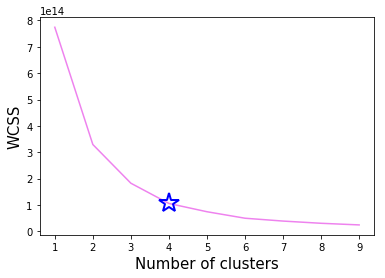

In [16]:
x = range(1, 10)
y = wcss

plt.plot(x,y, color= 'violet')
plt.plot(x[3], y[3], '*', ms=20, mec='blue', mfc='none', mew=2,)
plt.xlabel("Number of clusters", fontsize= 15, color='black')
plt.ylabel("WCSS", fontsize= 15, color='black')
plt.show()

How we can see from this image, we obtain an optimal situation with a number of clusters <b>k = 4</b>.

In [17]:
clust1 =KMeans(n_clusters= 4, init= 'k-means++').fit(df1)


In [18]:
#ann labels
labels1 = clust1.labels_
print(labels1)

[0 0 2 ... 0 2 0]


In [19]:
#for every cluster, the list of their announcements
dic={}

for i in range(len(labels1)):
    if labels1[i] not in dic:
        #there is not ann0, so increment i+1
        dic[labels1[i]] = [i+1]
    else:
        dic[labels1[i]].append(i+1)
 

In [20]:
wcss2=[]
for i in range(1, 10):
    kmeans_df2=KMeans(n_clusters = i, init = 'k-means++').fit(df2)
    wcss2.append(kmeans_df2.inertia_)
    


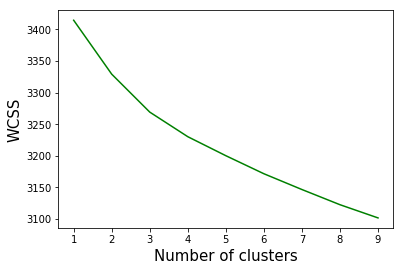

In [21]:
x = range(1, 10)
y = wcss2

plt.plot(x,y, color= 'green')

plt.xlabel("Number of clusters", fontsize= 15, color='black')
plt.ylabel("WCSS", fontsize= 15, color='black')
plt.show()

As we can see from this graphic, respect to the first case, now we have very high values of WCSS: it means that there is not really an optimal solution.

So we choose a number of clusters k = 4 again.

In [22]:
clust2 = KMeans(n_clusters= 4, init= 'k-means++').fit(df2)


In [23]:
labels2 = clust2.labels_
labels2


array([3, 0, 0, ..., 3, 2, 3], dtype=int32)

In [24]:
dic2 = {}
for i in range(len(labels2)):
    if labels2[i] not in dic2:
        dic2[labels2[i]] = [i+1]
    else:
        dic2[labels2[i]].append(i+1)
        


In [25]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [26]:
df_jaccard = pd.DataFrame(0, index=sorted(dic.keys()), columns=sorted(dic2.keys()))


In [27]:
for cluster in sorted(dic):
    for cluster2 in sorted(dic2):
        x = dic[cluster]
        y = dic2[cluster2]
        df_jaccard.loc[cluster, cluster2] = jaccard_similarity(x, y)
        
df_jaccard      
        
        

,0,1,2,3
0,0.139135,0.221039,0.235060,0.294618
1,0.069725,0.054475,0.047207,0.050592
2,0.128772,0.160309,0.129964,0.149182
3,0.008037,0.009050,0.003900,0.008485


Couple with higher jaccard similarity are (0,3), (0,2) and (0,1).

## Word Cloud of House Descriptions

In [34]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Our last goal is to create a <i>wordcloud</i> for each couple of optimal clusters resulted from the Jaccard analysis. 

The words that will be represented are those extracted from the description of the houses that are in the relative couple.

In [28]:
wc1= set(dic[0]).intersection(set(dic2[3]))
wc2= set(dic[0]).intersection(set(dic2[2]))
wc3= set(dic[0]).intersection(set(dic2[1]))

In [30]:
def create_string(wc):
    
    text1=""
    for ann in wc:
        announcement = "announcement"+str(ann)
        text_ann = " ".join(voc[announcement])

        text1 += text_ann
    return text1



In [31]:
txt1 = create_string(wc1)

In [35]:
def wc_image(text):
    
    wordcloud1 = WordCloud(width = 1000, height = 500,background_color='white').generate(text)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud1)
    plt.axis("off")

    plt.show()
    plt.close()
    

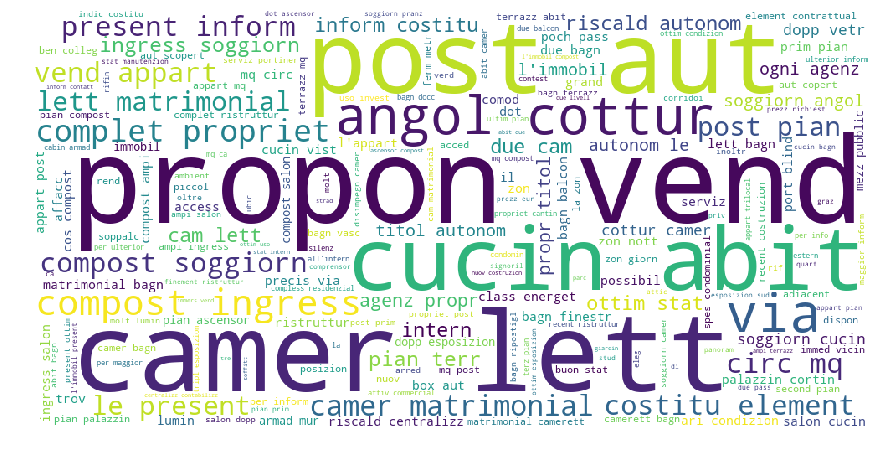

In [36]:
wc_image(txt1)

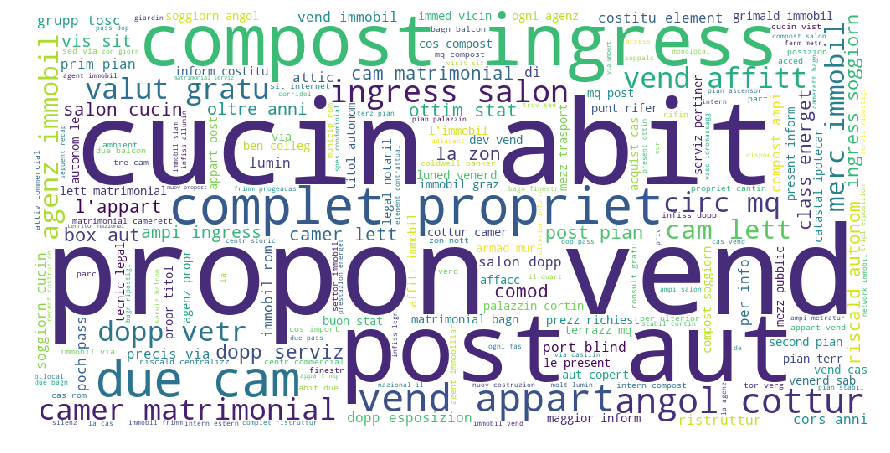

In [37]:
txt2 = create_string(wc2)
wc_image(txt2)

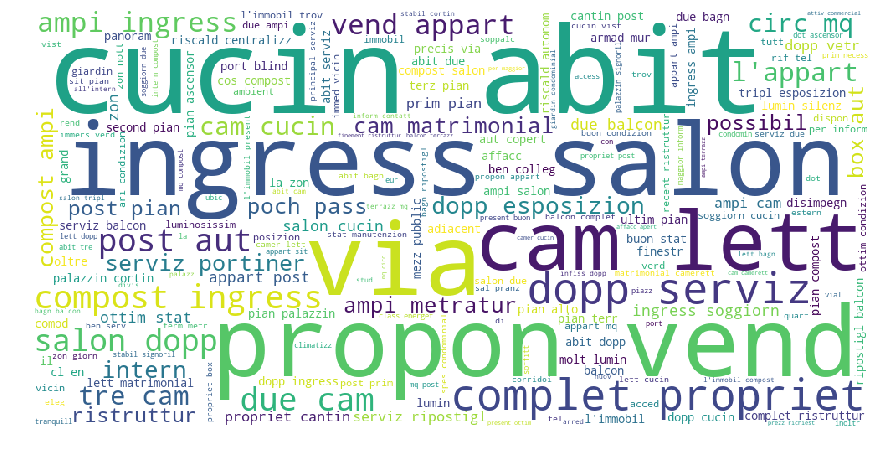

In [38]:
txt3 = create_string(wc3)
wc_image(txt3)